# Comparing `aiaprep`

In [1]:
import copy
import os
import pathlib
import glob

import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import astropy.units as u
import astropy.constants as const
import astropy.time
import drms
from sunpy.map import Map
from sunpy.util import MetaDict
from sunpy.instr.aia import aiaprep
import hissw
import skimage.measure
import scipy.signal

from aiapy.calibrate import update_pointing

%matplotlib inline

This notebook will do a systematic comparison between the `aiaprep` functionality in sunpy and ssw. Want to save out four different images per time step:

* Original image
* Fake circle image
* sunpy prepped fake image
* ssw prepped fake image

## Download Data
Grab a weeks worth of AIA data at a 1 day cadence

In [3]:
c = drms.Client(email='wtb2@rice.edu',)

In [11]:
r = c.export('aia.lev1_euv_12s[2019-03-01T00:00:00/7d@1d][171]{image}',method='url_quick')

In [13]:
df = r.download('prep_data/level_1/',fname_from_rec=True)

In [ ]:
files = sorted(df['download']tolist())

In [8]:
# If you don't need to download them again, just glob
files = sorted(glob.glob('prep_data/level_1/*'))

## Create Fake Data

In [9]:
def fake_circle_map(m):
    y_indices,x_indices = np.indices(m.data.shape)
    img_coords = m.pixel_to_world(y_indices*u.pixel,
                                  x_indices*u.pixel)
    rsun_obs = ((const.R_sun / (m.observer_coordinate.radius - const.R_sun)).decompose()* u.radian).to(u.arcsec)
    img_r = np.sqrt(img_coords.Tx**2 + img_coords.Ty**2)
    return Map((img_r < rsun_obs).astype(float), m.meta)

In [11]:
for f in files:
    fake_circle_map(Map(f)).save(
        (pathlib.Path('prep_data/level_1_fake/') 
         / pathlib.Path(f).name).as_posix(),
        overwrite=True
    )

## Prep SunPy
Quick reimplementation of the  `aiaprep` function in sunpy so that it uses the SDO master pointing table from JSOC and allows for passing in the `order` kwarg

In [16]:
def aiaprep_sunpy(aiamap, 
                  use_master_pointing=False,
                  order=4,
                  use_scipy=False,
                  missing=None):
    """
    Quick implementation of aiaprep as it appears in sunpy
    """
    if use_master_pointing:
        aiamap = update_pointing(aiamap)
        
    # Target scale is 0.6 arcsec/pixel, but this needs to be adjusted if the map
    # has already been rescaled.
    if ((aiamap.scale[0] / 0.6).round() != 1.0 * u.arcsec / u.pix
            and aiamap.data.shape != (4096, 4096)):
        scale = (aiamap.scale[0] / 0.6).round() * 0.6 * u.arcsec
    else:
        scale = 0.6 * u.arcsec
    scale_factor = aiamap.scale[0] / scale
    
    if missing is None:
        missing = aiamap.min()

    tempmap = aiamap.rotate(
        recenter=True,
        scale=scale_factor.value,
        missing=missing,
        order=order,
        use_scipy=use_scipy,
    )

    # extract center from padded aiamap.rotate output
    # crpix1 and crpix2 will be equal (recenter=True), as aiaprep does not work with submaps
    center = np.floor(tempmap.meta['crpix1'])
    range_side = (center + np.array([-1, 1]) * aiamap.data.shape[0] / 2) * u.pix
    newmap = tempmap.submap(u.Quantity([range_side[0], range_side[0]]),
                            u.Quantity([range_side[1], range_side[1]]))

    newmap.meta['r_sun'] = newmap.meta['rsun_obs'] / newmap.meta['cdelt1']
    newmap.meta['lvl_num'] = 1.5
    newmap.meta['bitpix'] = -64

    return newmap

In [17]:
fake_files = sorted(glob.glob('prep_data/level_1_fake/*'))

In [18]:
for f in fake_files:
    m = aiaprep_sunpy(Map(f), use_master_pointing=False)
    m.save((pathlib.Path('prep_data/prep_sunpy/') 
            / pathlib.Path(f).name).as_posix(),
           overwrite=True)

## Prep SSW
Just call `aiaprep` on the data

In [19]:
def aiaprep_ssw(filename):
    # Setup SSW environment
    script = """
    aia_prep,{{filenames}},{{indices}},oindex,odata
    """
    input_args = {
        'filenames': [filename],
        'indices': [0]
    }
    save_vars = ['oindex', 'odata']
    ssw = hissw.ScriptMaker(
        ssw_packages=['sdo/aia', 'vobs/ontology'],
        ssw_paths=['aia', 'ontology']
    )
    # Run prep procedure
    res = ssw.run(
        script,
        args=input_args,
        save_vars=save_vars,
        verbose=False
    )
    # Convert to sunpy map
    # Note: some keywords have to be converted to unicode
    meta = MetaDict({k:(res['oindex'][k][0]).decode('utf-8')
                     if type(res['oindex'][k][0]) is bytes else res['oindex'][k][0]
                     for k in res['oindex'].dtype.names})
    return Map(res['odata'], meta)

In [20]:
for f in fake_files:
    m = aiaprep_ssw(f)
    del m.meta['history']
    del m.meta['comment']
    m.save((pathlib.Path('prep_data/prep_ssw/')
            / pathlib.Path(f).name).as_posix(),
           overwrite=True)

## Comparison

First, just do a quick difference between the two cases.

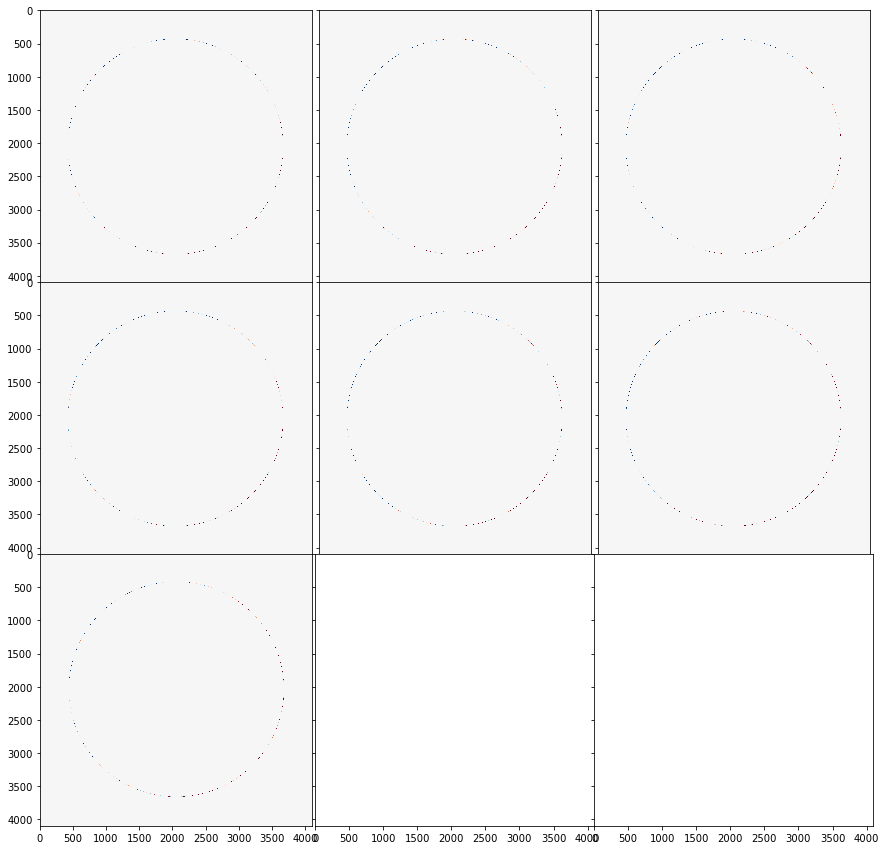

In [2]:
fig,axes = plt.subplots(3,3,figsize=(15,15),sharex=True,sharey=True)
for ax,f in zip(axes.flatten(),sorted(glob.glob('prep_data/prep_sunpy/*.fits'))):
    name = pathlib.Path(f).name
    m_sunpy = Map(f)
    m_ssw = Map((pathlib.Path('prep_data/prep_ssw/') / name).as_posix())
    ax.imshow(m_ssw.data - m_sunpy.data, vmin=-0.3, vmax=0.3, cmap='RdBu')
plt.subplots_adjust(wspace=0,hspace=0)

Next, let's plot a single row as afunction of pixel across the disk to look at how the sunpy IDL approaches handle interpolation.

In [23]:
m_sunpy = Map('prep_data/prep_sunpy/aia.lev1_euv_12s.20190228T235959Z.171.image_lev1.fits')
m_ssw = Map('prep_data/prep_ssw/aia.lev1_euv_12s.20190228T235959Z.171.image_lev1.fits')

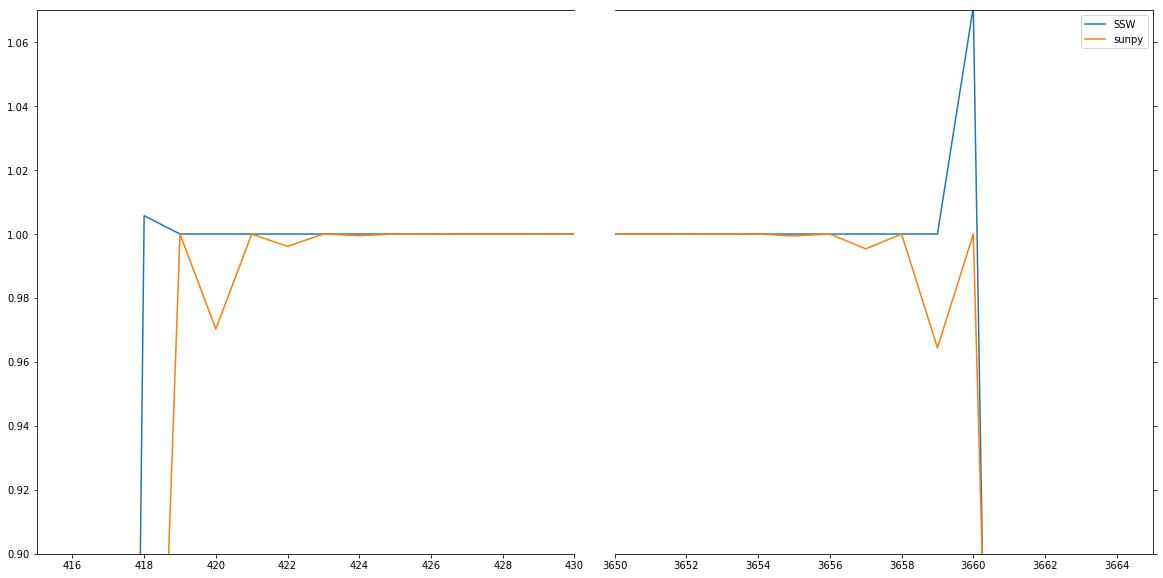

In [65]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10),sharey=True)
# Left
ax1.plot(m_ssw.data[m_ssw.data.shape[0]//2, :], label='SSW')
ax1.plot(m_sunpy.data[m_sunpy.data.shape[0]//2, :], label='sunpy')
ax1.set_ylim(0.9,1.07)
ax1.set_xlim(415,430)
# Right
ax2.plot(m_ssw.data[m_ssw.data.shape[0]//2, :], label='SSW')
ax2.plot(m_sunpy.data[m_sunpy.data.shape[0]//2, :], label='sunpy')
ax2.set_xlim(3650,3665)
ax2.legend()
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)
ax2.yaxis.tick_right()
plt.subplots_adjust(wspace=0.075)

Now, let's compare this ringing behavior for different interpolation schemes for sunpy

In [68]:
m_test = Map('prep_data/level_1_fake/aia.lev1_euv_12s.20190228T235959Z.171.image_lev1.fits')

In [69]:
orders = [2, 3, 4, 2, 3, 4]
use_scipy = 3*(False,) + 3*(True,)
labels = [
    'order=2, skimage',
    'order=3, skimage',
    'order=4, skimage',
    'order=2, scipy',
    'order=3, scipy',
    'order=4, scipy',
]

In [70]:
maps_interp = []
for o,b in zip(orders,use_scipy):
    maps_interp.append(aiaprep_sunpy(m_test, order=o, use_scipy=b))

/Users/barnes/anaconda3/envs/aiapy-dev/lib/python3.7/site-packages/skimage/transform/_warps.py:833: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  warn("Bi-quadratic interpolation behavior has changed due "


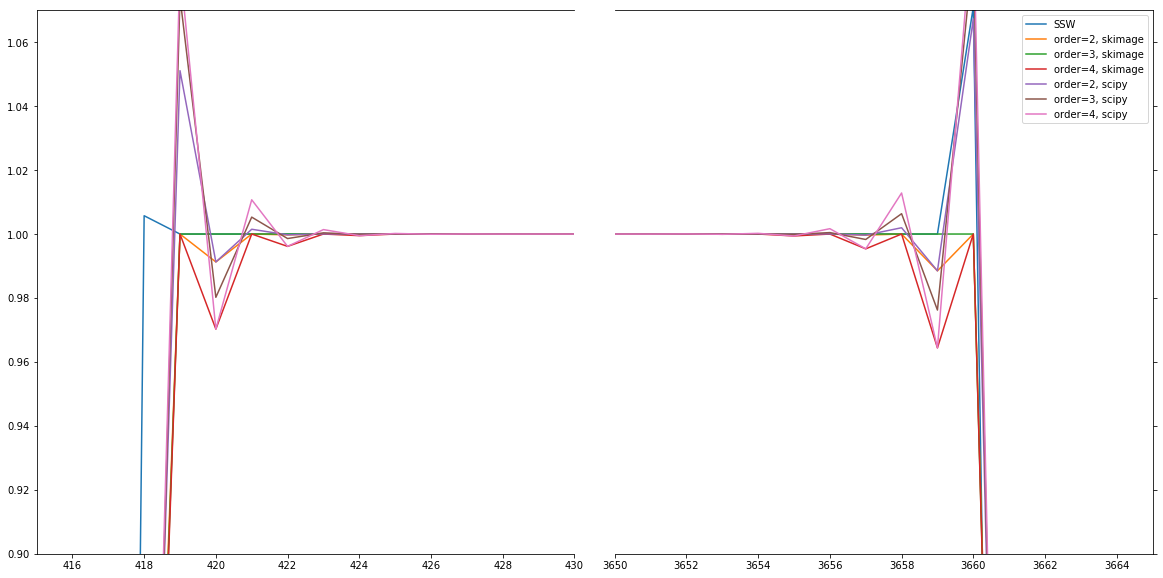

In [71]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10),sharey=True)
# Left
ax1.plot(m_ssw.data[m_ssw.data.shape[0]//2, :], label='SSW')
for mi,l in zip(maps_interp, labels):
    ax1.plot(mi.data[mi.data.shape[0]//2, :], label=l)
ax1.set_ylim(0.9,1.07)
ax1.set_xlim(415,430)
# Right
ax2.plot(m_ssw.data[m_ssw.data.shape[0]//2, :], label='SSW')
for mi,l in zip(maps_interp, labels):
    ax2.plot(mi.data[mi.data.shape[0]//2, :], label=l)
ax2.set_xlim(3650,3665)
ax2.legend()
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)
ax2.yaxis.tick_right()
plt.subplots_adjust(wspace=0.075)

It looks like using scikit-image with order=3 is the best solution.

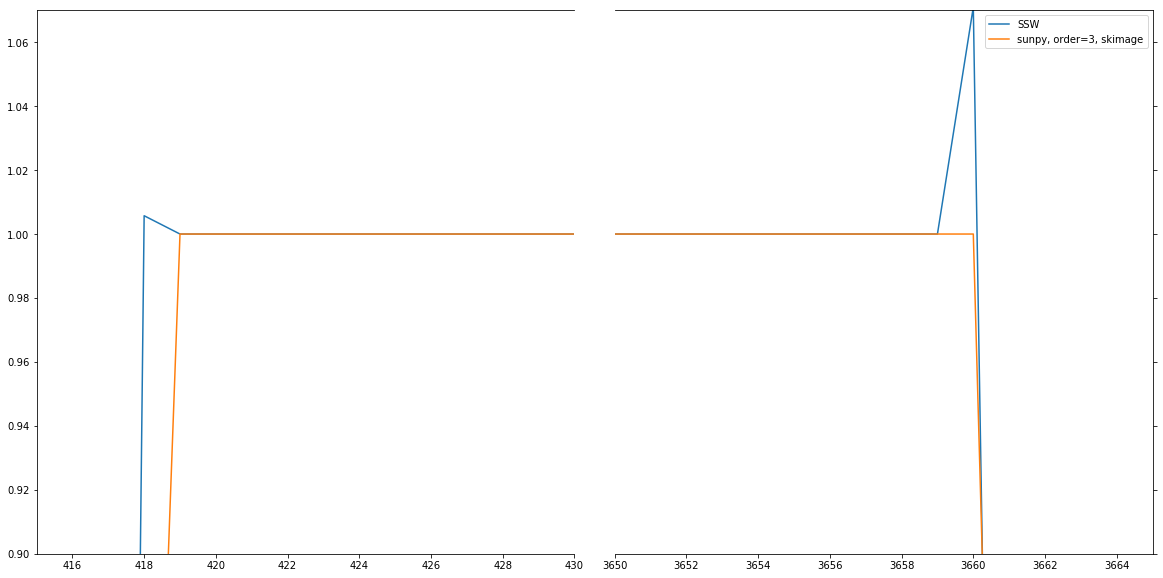

In [73]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10),sharey=True)
# Left
ax1.plot(m_ssw.data[m_ssw.data.shape[0]//2, :], label='SSW')
ax1.plot(maps_interp[1].data[maps_interp[1].data.shape[0]//2, :], label=f'sunpy, {labels[1]}')
ax1.set_ylim(0.9,1.07)
ax1.set_xlim(415,430)
# Right
ax2.plot(m_ssw.data[m_ssw.data.shape[0]//2, :], label='SSW')
ax2.plot(maps_interp[1].data[maps_interp[1].data.shape[0]//2, :], label=f'sunpy, {labels[1]}')
ax2.set_xlim(3650,3665)
ax2.legend()
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)
ax2.yaxis.tick_right()
plt.subplots_adjust(wspace=0.075)

Now, what if we redo the above comparison with this improved interpolation scheme?

In [74]:
for f in fake_files:
    m = aiaprep_sunpy(Map(f), use_master_pointing=False, order=3, use_scipy=False,)
    m.save((pathlib.Path('prep_data/prep_sunpy/skimage_order3/') 
            / pathlib.Path(f).name).as_posix(),
           overwrite=True)

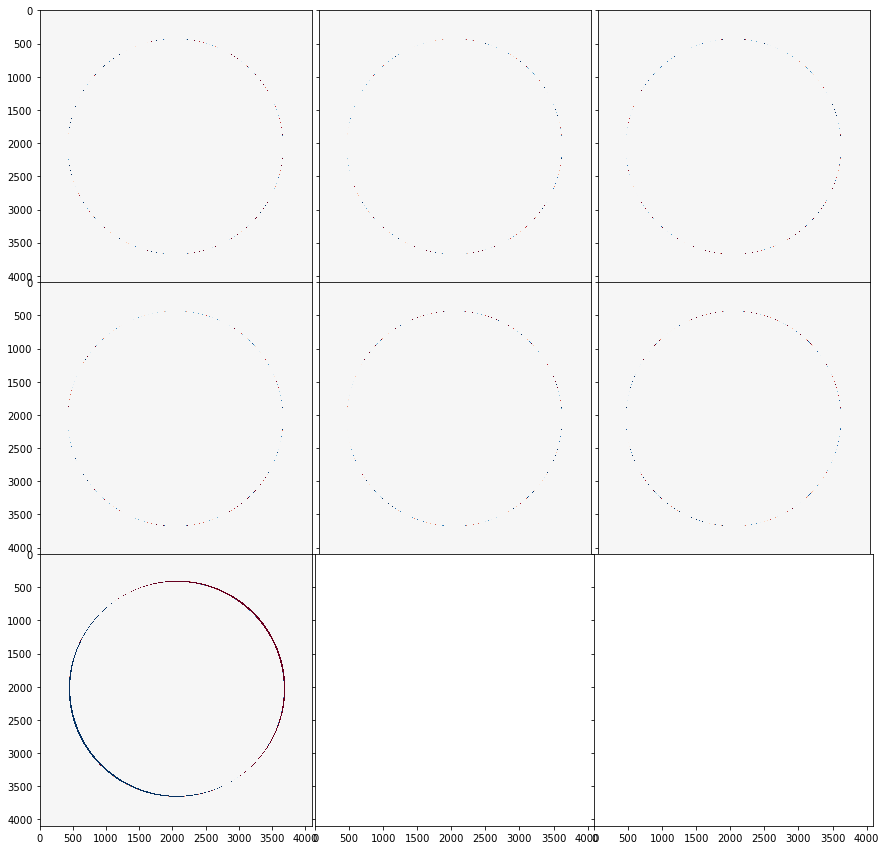

In [76]:
fig,axes = plt.subplots(3,3,figsize=(15,15),sharex=True,sharey=True)
for ax,f in zip(axes.flatten(),sorted(glob.glob('prep_data/prep_sunpy/skimage_order3/*.fits'))):
    name = pathlib.Path(f).name
    m_sunpy = Map(f)
    m_ssw = Map((pathlib.Path('prep_data/prep_ssw/') / name).as_posix())
    ax.imshow(m_ssw.data - m_sunpy.data, vmin=-0.1, vmax=0.1, cmap='RdBu')
plt.subplots_adjust(wspace=0,hspace=0)

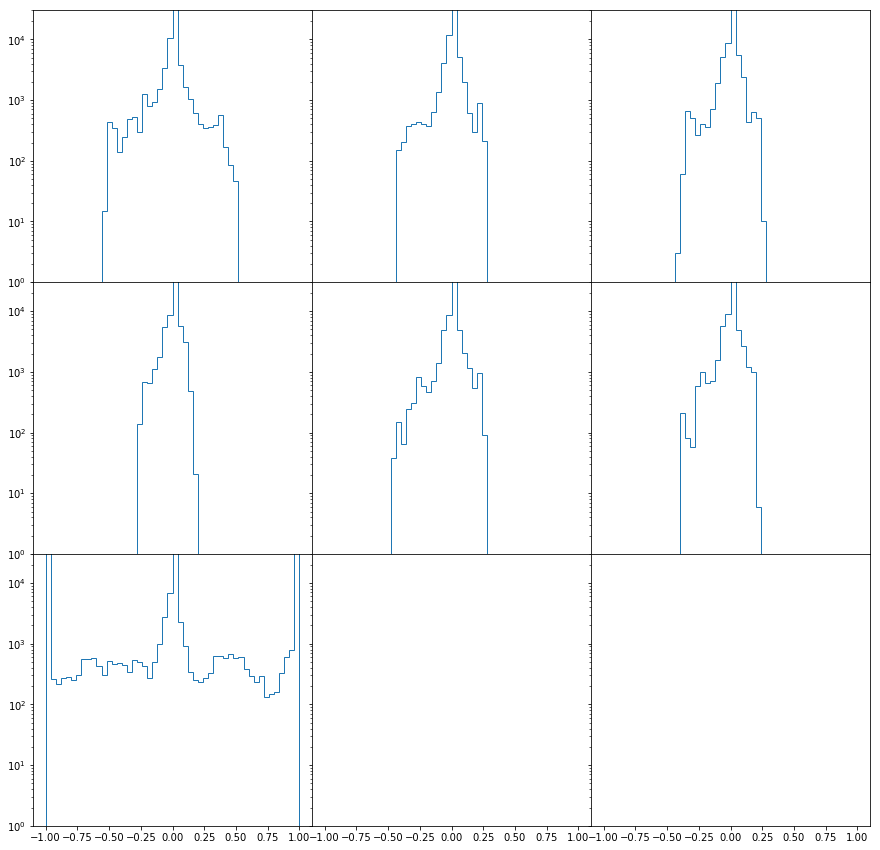

In [83]:
fig,axes = plt.subplots(3,3,figsize=(15,15),sharex=True,sharey=True)
for ax,f in zip(axes.flatten(),sorted(glob.glob('prep_data/prep_sunpy/skimage_order3/*.fits'))):
    name = pathlib.Path(f).name
    m_sunpy = Map(f)
    m_ssw = Map((pathlib.Path('prep_data/prep_ssw/') / name).as_posix())
    diff = (m_ssw.data - m_sunpy.data).flatten()
    ax.hist(diff, bins=50, range=(-1,1),log=True, histtype='step')
ax.set_ylim(1,3e4)
plt.subplots_adjust(wspace=0,hspace=0)